In [1]:
import sys
import typing
import os
import glob
import PIL
import tqdm
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 100)
import seaborn as sns

# hint: notebook is executed in jupyter lab dark mode
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# # see https://matplotlib.org/gallery/style_sheets/style_sheets_reference.html for styles
# plt.style.use('dark_background')
# # global color settings (use white/grey for jupyterlab dark mode
# # and black/grey for jupyterlab light mode)
# COLOR = 'grey'
# plt.rcParams['text.color'] = COLOR
# plt.rcParams['axes.labelcolor'] = COLOR
# plt.rcParams['xtick.color'] = COLOR
# plt.rcParams['ytick.color'] = COLOR
# # plt.rcParams['grid.color'] = COLOR
# # plt.rcParams['figure.edgecolor'] = 'red'
plt.rcParams['figure.figsize'] = (12, 6)

print(f'Python version: {sys.version}')
print(f'Numpy version: {np.__version__}')
print(f'Pandas version: {pd.__version__}')

## create figure path if it does not exist
path_figures = 'figs/eda/'
os.makedirs(path_figures, exist_ok=True)

Python version: 3.8.3 (default, May 19 2020, 18:47:26) 
[GCC 7.3.0]
Numpy version: 1.18.1
Pandas version: 1.0.3


# Exploratory Data Analysis (EDA)
## Importing and editing overview dataframes
Import DataFrame that contains overview of the image data.
We add some relevant columns, rename columns and introduce machine readable (OHE) labels.

In [2]:
## for downloading the zip archive of the dataset:
# import kaggle
# kaggle datasets download -d nih-chest-xrays/data
## then unpack the the .zip archive

In [3]:
# dictionary for renaming columns of original dataset:
dict_columns_original = {
    'Image Index': 'iid',
    'Finding Labels': 'finding_labels',
    'Follow-up #': 'nr_follow_up',
    'Patient ID': 'pid',
    'Patient Age': 'patient_age',
    'Patient Gender': 'patient_gender',
    'View Position': 'view_position',
    'OriginalImage[Width': 'oimage_width',
    'OriginalImageWidth': 'oimage_width',
    'Height]': 'oimage_height',
    'OriginalImageHeight': 'oimage_height',
    'OriginalImagePixelSpacing[x': 'oimage_px_spacing_x',
    'OriginalImagePixelSpacing_x': 'oimage_px_spacing_x',
    'y]': 'oimage_px_spacing_y',
    'OriginalImagePixelSpacing_y': 'oimage_px_spacing_y',
}

data_dir = 'data/'

## load NIH data
df = pd.read_csv(f'{data_dir}Data_Entry_2017.csv')
## rename columns
df.columns = df.columns.map(dict_columns_original)
## select relevant columns
df = df[dict_columns_original.values()]
## we have to drop duplicate columns because we introduce
## some duplicates above:
df = df.loc[:, ~df.columns.duplicated()]
## edit string columns to lower case:
df['finding_labels'] = df['finding_labels'].str.lower().str.replace(' ', '_')
df['patient_gender'] = df['patient_gender'].str.lower()
df['view_position'] = df['view_position'].str.lower()


## append file-paths
## loop through all data sub-directories
lst_files = []
for i in range(1, 13):
    ## get all files in this directory
    path = f'{data_dir}images_{i:03}/images/'
    lst_files += glob.glob(path + '*.png')

## cast to pd.Series:
ser_files = pd.Series(lst_files)
## split filepath to separate file from path
df_files = ser_files.str.rsplit('/', n=1, expand=True)
## rename df:
df_files.columns = ['file_path', 'iid']
## replace file_path with complete file path (from above)
df_files['file_path'] = ser_files
## append file path to dataframe:
df = df.merge(df_files, on='iid', how='left')


## perform OHE on 'finding_labels' column:
df_labels = pd.get_dummies(df['finding_labels']
                           .str.split('|', expand=True),
                           prefix='label')
## group same labels:
df_labels = df_labels.groupby(df_labels.columns, axis=1).sum()
## update dataframe with the OHE labels:
df = pd.concat([df, df_labels], axis=1, sort=False)

In [4]:
## load 'sample_labels.csv' data for pixel level assessments
df_sample = pd.read_csv('sample_labels.csv')
## rename columns
df_sample.columns = df_sample.columns.map(dict_columns_original)
## select relevant columns
df_sample = df_sample[dict_columns_original.values()]
## we have to drop duplicate columns because we introduce
## some duplicates above:
df_sample = df_sample.loc[:, ~df_sample.columns.duplicated()]
## edit string columns to lower case:
df_sample['finding_labels'] = df_sample['finding_labels'].str.lower().str.replace(' ', '_')
df_sample['patient_gender'] = df_sample['patient_gender'].str.lower()
df_sample['view_position'] = df_sample['view_position'].str.lower()
# ATTENTION: the patient's age is given in a string in df_sample
df_sample['patient_age'] = df_sample['patient_age'].str.lower()
## transform patient_age to numerical value:
df_sample['patient_age_unit'] = df_sample['patient_age'].str[-1]
df_sample['patient_age_value'] = df_sample['patient_age'].str[:-1].astype('int')


## append file path to dataframe:
df_sample = df_sample.merge(df_files, on='iid', how='left')


## perform OHE on 'finding_labels' column:
df_sample_labels = pd.get_dummies(df_sample['finding_labels']
                                  .str.split('|', expand=True),
                                  prefix='label')
## group same labels:
df_sample_labels = df_sample_labels.groupby(df_sample_labels.columns, axis=1).sum()
## update dataframe with the OHE labels:
df_sample = pd.concat([df_sample, df_sample_labels], axis=1, sort=False)

In [5]:
df_sample['patient_age_unit'].value_counts()

y    5604
m       1
d       1
Name: patient_age_unit, dtype: int64

most of the patient age values are in years. transform all entries to years:

In [6]:
# transform patient age
df_sample.loc[df_sample['patient_age_unit']=='d',
              'patient_age'] = df_sample.loc[df_sample['patient_age_unit']=='d',
                                             'patient_age_value'] // 365
df_sample.loc[df_sample['patient_age_unit']=='m',
              'patient_age'] = df_sample.loc[df_sample['patient_age_unit']=='m',
                                             'patient_age_value'] // 12
df_sample.loc[df_sample['patient_age_unit']=='y',
              'patient_age'] = df_sample.loc[df_sample['patient_age_unit']=='y',
                                             'patient_age_value']
# drop helper columns
df_sample = df_sample.drop(['patient_age_value', 'patient_age_unit'], axis=1)

## Dataset explanation:
- all images have pixel size 1024x1024
- iid: Image Index/ File name
- finding_labels: Disease type (Class label)
- 'nr_follow_up': for a given patient ('pid') the number of follow-up chest x-ray scan. the first scan has 'nr_follow_up'==0, the second ==1, and so on. The time between two scans is not given.
- 'pid': unique patient id
- 'patient_age': patient age in years
- patient_gender: \elem ['m', 'f']
- 'view_position': 2 values:
    - pa: In a posteroanterior (PA) view, the x-ray source is positioned so that the x-ray beam enters through the posterior (back) aspect of the chest and exits out of the anterior (front) aspect, where the beam is detected.
    - ap: The erect anteroposterior chest view is performed with the x-ray tube anteriorly, firing photons through the patient to form the image on a detector positioned behind the patient.
- 'oimage_width': original image widht
- 'oimage_height': original image height
- 'oimage_px_spacing_x': Physical distance in the patient between the centers of two 2D pixels (2 adjacent columns, or horizontal spacing) in mm in x direction, also called column spacing
- 'oimage_px_spacing_y': Physical distance in the patient between the center of each pixel (2 adjacent rows, or vertical spacing) in mm in y direction, also called row spacing
- 'file_path': path to image files
- 'label_*': label of all deseases/findings. There are the following deseases:
    - atelectasis
    - cardiomegaly
    - consolidation
    - edema
    - effusion
    - emphysema
    - fibrosis
    - hernia
    - infiltration
    - mass
    - no_finding
    - nodule
    - pleural_thickening
    - pneumonia
    - pneumothorax

## Consistency check and data selection
Let us consider the patient's ages of patients with pneumonia and without pneumonia.
We especially look at the age limits:

In [7]:
print('display ages (indices) of patients with pneumonia (lower age range):')
df[df['label_pneumonia']==1]['patient_age'].value_counts().sort_index().head()

display ages (indices) of patients with pneumonia (lower age range):


2    1
3    4
4    2
5    6
6    2
Name: patient_age, dtype: int64

In [8]:
print('display ages (indices) of patients with pneumonia (upper age range):')
df[df['label_pneumonia']==1]['patient_age'].value_counts().sort_index().tail()

display ages (indices) of patients with pneumonia (upper age range):


84     1
85     1
87     1
90     1
412    1
Name: patient_age, dtype: int64

In [9]:
print('display ages (indices) of patients of total dataset (lower age range):')
df['patient_age'].value_counts().sort_index().head()

display ages (indices) of patients of total dataset (lower age range):


1     16
2     83
3     84
4    105
5    137
Name: patient_age, dtype: int64

In [10]:
print('display ages (indices) of patients of total dataset (upper age range):')
df['patient_age'].value_counts().sort_index().tail(15)

display ages (indices) of patients of total dataset (upper age range):


93     9
94     8
95     1
148    2
149    1
150    1
151    1
152    1
153    1
154    1
155    2
411    1
412    3
413    1
414    1
Name: patient_age, dtype: int64

We can see that there are some errors in the dataset.
Most probably errors occured in the data curration process.
There are images of patients who are >100 years of age.

Furthermore there are errors in the 'nr_follow_up' column.
X-ray follow-up scans do not match with the patient's age.

In [11]:
df.loc[df['pid']==13, ['patient_age', 'nr_follow_up']].sort_values('nr_follow_up')

,patient_age,nr_follow_up
38,61,0
39,60,1
40,60,2
41,60,3
42,60,4
43,60,5
44,60,6
45,60,7
46,60,8
47,60,9


As a result of the above analysis we will ignore column 'follow_up' to a great extend.
We are also going to remove ages above 100 years:

In [12]:
msk = df['patient_age']<100
print(f'# images which will be deleted later because of wrong age value: {(~msk).sum()}')
df = df[msk]

# images which will be deleted later because of wrong age value: 16


In [13]:
df.dtypes

iid                          object
finding_labels               object
nr_follow_up                  int64
pid                           int64
patient_age                   int64
patient_gender               object
view_position                object
oimage_width                  int64
oimage_height                 int64
oimage_px_spacing_x         float64
oimage_px_spacing_y         float64
file_path                    object
label_atelectasis             uint8
label_cardiomegaly            uint8
label_consolidation           uint8
label_edema                   uint8
label_effusion                uint8
label_emphysema               uint8
label_fibrosis                uint8
label_hernia                  uint8
label_infiltration            uint8
label_mass                    uint8
label_no_finding              uint8
label_nodule                  uint8
label_pleural_thickening      uint8
label_pneumonia               uint8
label_pneumothorax            uint8
dtype: object

In [14]:
df_sample.dtypes

iid                          object
finding_labels               object
nr_follow_up                  int64
pid                           int64
patient_age                  object
patient_gender               object
view_position                object
oimage_width                  int64
oimage_height                 int64
oimage_px_spacing_x         float64
oimage_px_spacing_y         float64
file_path                    object
label_atelectasis             uint8
label_cardiomegaly            uint8
label_consolidation           uint8
label_edema                   uint8
label_effusion                uint8
label_emphysema               uint8
label_fibrosis                uint8
label_hernia                  uint8
label_infiltration            uint8
label_mass                    uint8
label_no_finding              uint8
label_nodule                  uint8
label_pleural_thickening      uint8
label_pneumonia               uint8
label_pneumothorax            uint8
dtype: object

In [15]:
## save dataframe
## uncomment the following line if pytables is not installed:
# !conda install pytables -y
# !pip install tables
df.to_hdf(path_or_buf='data_summary.hdf', key='df')

## EDA of metadata
* The patient demographic data (as it is available)
    - gender
    - age
    - patient position 
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 



### Age

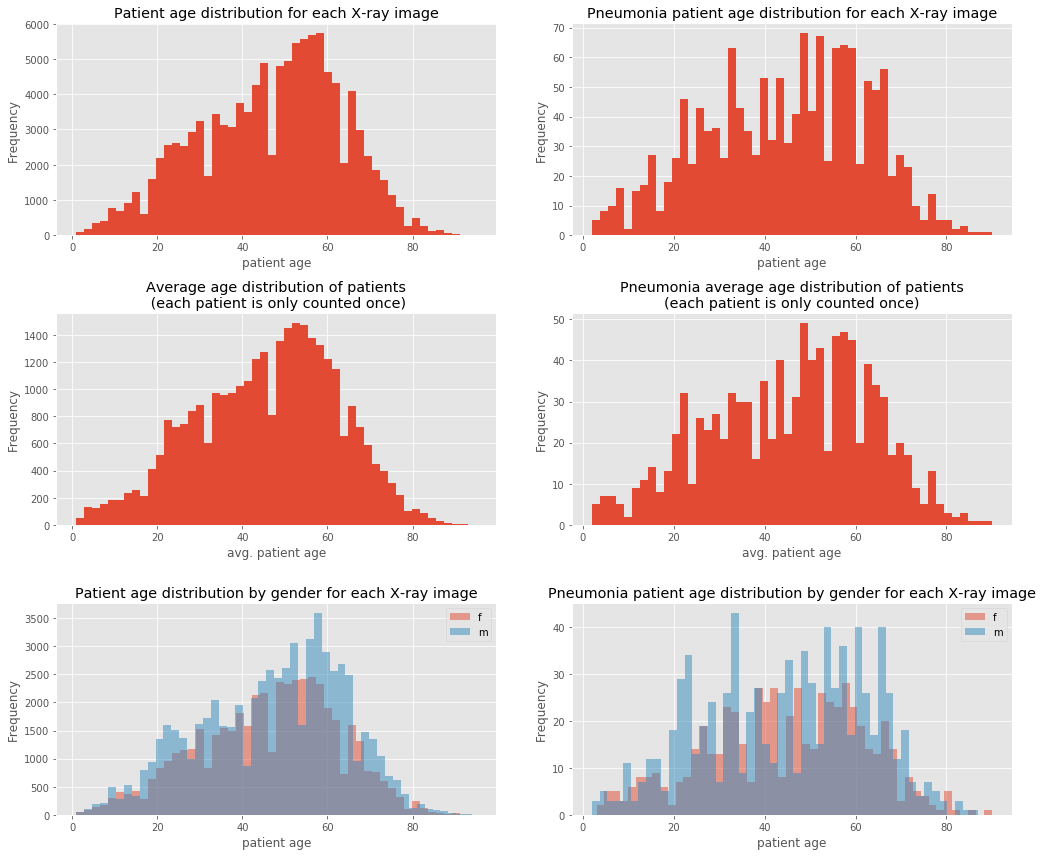

In [16]:
fig, axarr = plt.subplots(3, 2, figsize=(15, 12))

ttl = 'Patient age distribution for each X-ray image'
df_plot = df['patient_age']
ser_stats_age_dataset = df_plot.agg(['mean', 'std'])
df_plot.plot.hist(title=ttl, ax=axarr[0, 0], bins=50)
axarr[0, 0].set_xlabel('patient age')

ttl = 'Average age distribution of patients\n (each patient is only counted once)'
df_plot = df.groupby('pid')['patient_age'].mean()
df_plot.plot.hist(ax=axarr[1, 0], title=ttl, bins=50)
axarr[1, 0].set_xlabel('avg. patient age')

ttl = 'Pneumonia patient age distribution for each X-ray image'
df_plot = df.loc[df['label_pneumonia']==1, 'patient_age']
df_plot.plot.hist(title=ttl, ax=axarr[0, 1], bins=50)
axarr[0, 1].set_xlabel('patient age')

ttl = 'Pneumonia average age distribution of patients\n(each patient is only counted once)'
df_plot = (df[df['label_pneumonia']==1]
           .groupby('pid')['patient_age']
           .mean())
df_plot.plot.hist(ax=axarr[1, 1], title=ttl, bins=50)
axarr[1, 1].set_xlabel('avg. patient age')

ttl = 'Patient age distribution by gender for each X-ray image'
df_plot = df.groupby('patient_gender')['patient_age']
df_plot.plot.hist(legend=True, title=ttl, alpha=0.5, bins=50, ax=axarr[2, 0])
axarr[2, 0].set_xlabel('patient age')

ttl = 'Pneumonia patient age distribution by gender for each X-ray image'
df_plot = (df[df['label_pneumonia']==1]
           .groupby('patient_gender')['patient_age'])
df_plot.plot.hist(legend=True, title=ttl, alpha=0.5, bins=50, ax=axarr[2,1])
axarr[2, 1].set_xlabel('patient age')
fig.tight_layout()
plt.savefig(f'{path_figures}age_distributions.png', bbox_inches='tight')

### Gender

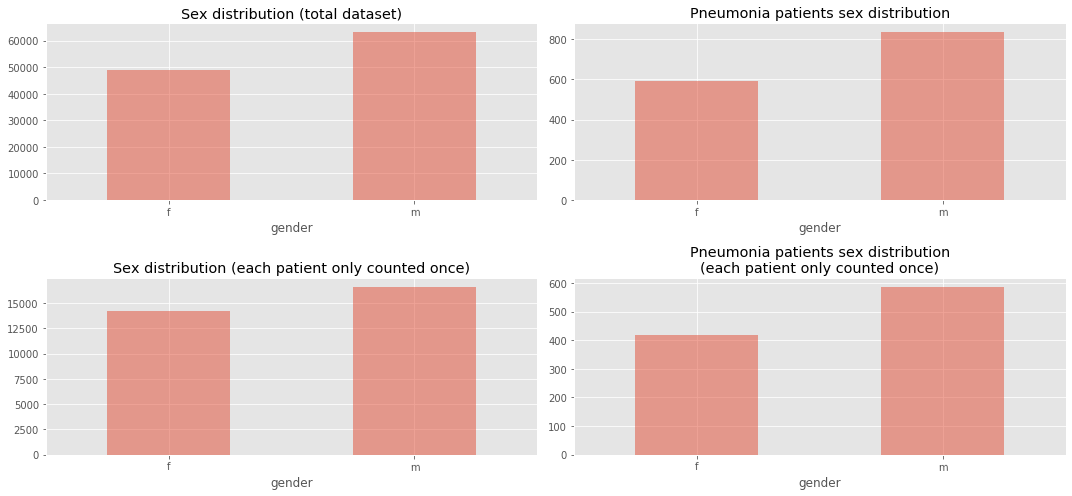

In [17]:
fig, axarr = plt.subplots(2, 2, figsize=(15, 7))

ttl = 'Sex distribution (total dataset)'
(df['patient_gender']
 .value_counts()
 .sort_index()
 .plot.bar(ax=axarr[0, 0], alpha=0.5, title=ttl, rot=1))
axarr[0, 0].set_xlabel('gender')

ttl = 'Pneumonia patients sex distribution'
(df.loc[df['label_pneumonia']==1, 'patient_gender']
 .value_counts()
 .sort_index()
 .plot.bar(ax=axarr[0, 1], alpha=0.5, title=ttl, rot=1))
axarr[0, 1].set_xlabel('gender')

ttl = 'Sex distribution (each patient only counted once)'
(df.drop_duplicates(subset='pid', keep='first')['patient_gender']
 .value_counts()
 .sort_index()
 .plot.bar(ax=axarr[1, 0], alpha=0.5, title=ttl, rot=1))
axarr[1, 0].set_xlabel('gender')

ttl = 'Pneumonia patients sex distribution\n(each patient only counted once)'
(df[df['label_pneumonia']==1]
 .drop_duplicates(subset='pid', keep='first')['patient_gender']
 .value_counts()
 .sort_index()
 .plot.bar(ax=axarr[1, 1], alpha=0.5, title=ttl, rot=1))
axarr[1, 1].set_xlabel('gender')

fig.tight_layout()
plt.savefig(f'{path_figures}sex_distributions.png', bbox_inches='tight')

### View position

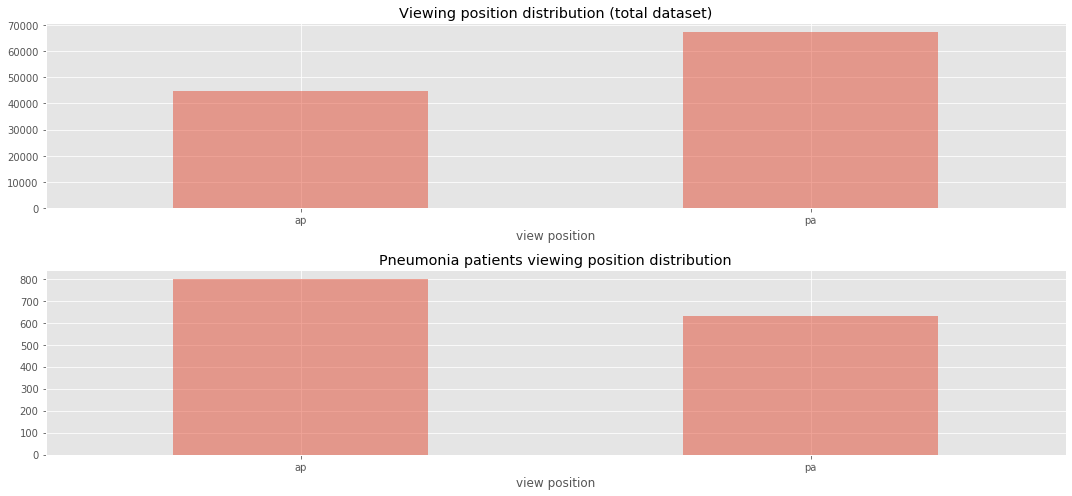

In [18]:
fig, axarr = plt.subplots(2, 1, figsize=(15, 7))

ttl = 'Viewing position distribution (total dataset)'
(df['view_position']
 .value_counts()
 .sort_index()
 .plot.bar(ax=axarr[0], alpha=0.5, title=ttl, rot=1))
axarr[0].set_xlabel('view position')

ttl = 'Pneumonia patients viewing position distribution'
(df.loc[df['label_pneumonia']==1, 'view_position']
 .value_counts()
 .sort_index()
 .plot.bar(ax=axarr[1], alpha=0.5, title=ttl, rot=1))
axarr[1].set_xlabel('view position')

fig.tight_layout()
plt.savefig(f'{path_figures}viewing_posistion_distribution.png', bbox_inches='tight')

Patients with pneumonia are positioned more often in position view 'AP' while in the total dataset the dominating position view is 'PA'. This effect can be eliminated by augmenting our training dataset by **flipping images horizontally**.

### Number of scans per patient

In [19]:
print('Scans per patient: Avergage number of scans, Standard diviation of scans and median of scans:')
df.groupby('pid').size().agg(['mean', 'std', 'median'])

Scans per patient: Avergage number of scans, Standard diviation of scans and median of scans:


mean      3.639504
std       7.266232
median    1.000000
dtype: float64

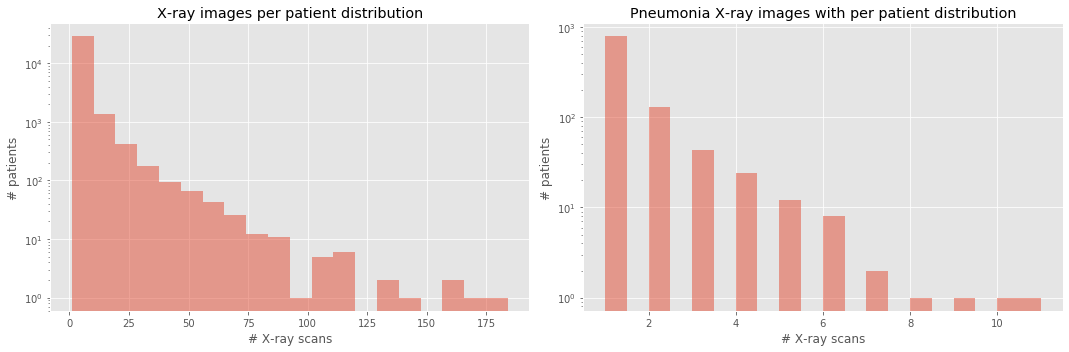

In [20]:
fig, axarr = plt.subplots(1, 2, figsize=(15, 5))

ttl = 'X-ray images per patient distribution'
df.groupby('pid').size().plot.hist(ax=axarr[0], title=ttl, bins=20, logy=True, alpha=0.5)
axarr[0].set_xlabel('# X-ray scans')
axarr[0].set_ylabel('# patients')

ttl = 'Pneumonia X-ray images with per patient distribution'
df[df['label_pneumonia']==1].groupby('pid').size().plot.hist(ax=axarr[1], title=ttl, bins=20, logy=True, alpha=0.5)
axarr[1].set_xlabel('# X-ray scans')
axarr[1].set_ylabel('# patients')

fig.tight_layout()
plt.savefig(f'{path_figures}nr_scans.png', bbox_inches='tight')

In [21]:
df[df['pid']==4006].head()

,iid,finding_labels,nr_follow_up,pid,patient_age,patient_gender,view_position,oimage_width,oimage_height,oimage_px_spacing_x,oimage_px_spacing_y,file_path,label_atelectasis,label_cardiomegaly,label_consolidation,label_edema,label_effusion,label_emphysema,label_fibrosis,label_hernia,label_infiltration,label_mass,label_no_finding,label_nodule,label_pleural_thickening,label_pneumonia,label_pneumothorax
15279,00004006_000.png,no_finding,0,4006,39,f,pa,2544,3056,0.139,0.139,data/images_003/images/00004006_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
15280,00004006_001.png,no_finding,1,4006,31,f,ap,2500,2048,0.171,0.171,data/images_003/images/00004006_001.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
15281,00004006_002.png,no_finding,2,4006,31,f,ap,2500,2048,0.171,0.171,data/images_003/images/00004006_002.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
15282,00004006_003.png,no_finding,3,4006,31,f,ap,2500,2048,0.168,0.168,data/images_003/images/00004006_003.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
15283,00004006_004.png,no_finding,4,4006,31,f,ap,2500,2048,0.168,0.168,data/images_003/images/00004006_004.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


### Pneumonia disease

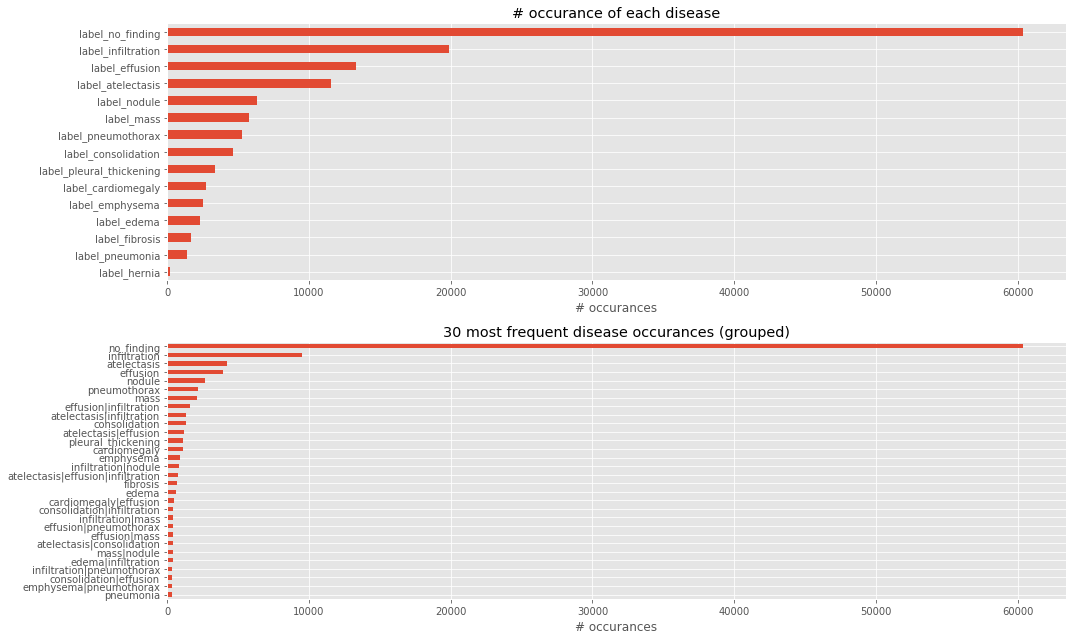

In [22]:
fig, axarr = plt.subplots(2, 1, figsize=(15, 9))
ttl = '# occurance of each disease'
df.loc[:, df.columns.str.startswith('label')].sum().sort_values(ascending=False).plot.barh(ax=axarr[0], title=ttl)
axarr[0].set_xlabel('# occurances')
axarr[0].invert_yaxis()

ttl = '30 most frequent disease occurances (grouped)'
df['finding_labels'].value_counts()[:30].plot.barh(ax=axarr[1], title=ttl)
axarr[1].set_xlabel('# occurances')
axarr[1].invert_yaxis()

fig.tight_layout()
plt.savefig(f'{path_figures}occurance_of_diseases.png', bbox_inches='tight')

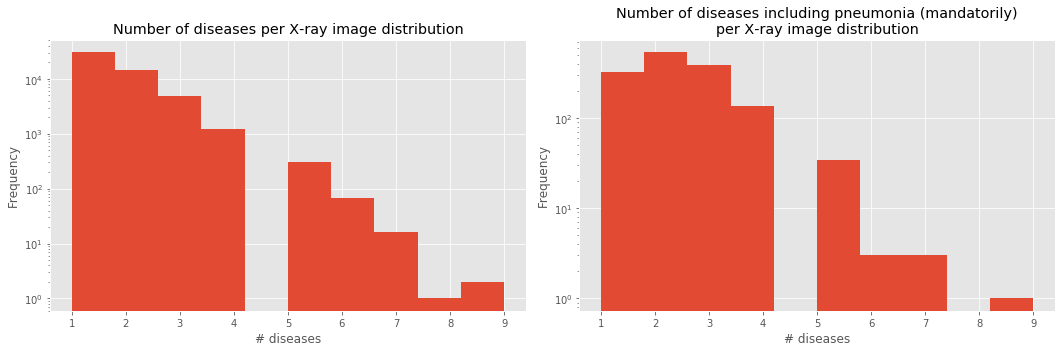

In [23]:
fig, axarr = plt.subplots(1, 2, figsize=(15, 5))

ttl = 'Number of diseases per X-ray image distribution'
df.loc[df['label_no_finding']==0, df.columns.str.startswith('label')].sum(axis=1).plot.hist(logy=True, ax=axarr[0], title=ttl)
axarr[0].set_xlabel('# diseases')

ttl = 'Number of diseases including pneumonia (mandatorily)\nper X-ray image distribution'
df.loc[(df['label_no_finding']==0) & (df['label_pneumonia']==1), df.columns.str.startswith('label')].sum(axis=1).plot.hist(logy=True, ax=axarr[1], title=ttl)
axarr[1].set_xlabel('# diseases')

fig.tight_layout()
plt.savefig(f'{path_figures}nr_of_diseases_per_image.png', bbox_inches='tight')

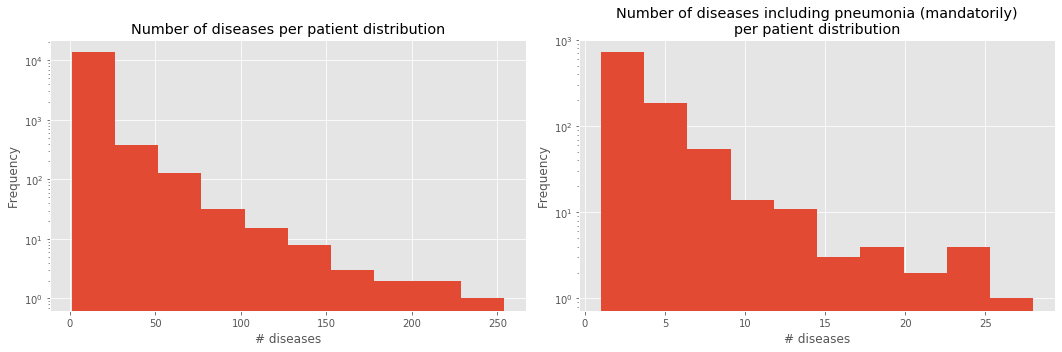

In [24]:
fig, axarr = plt.subplots(1, 2, figsize=(15, 5))

ttl = 'Number of diseases per patient distribution'
df.loc[df['label_no_finding']==0, df.columns.str.contains('label_|pid', regex=True)].groupby('pid').sum().sum(axis=1).plot.hist(ax=axarr[0], title=ttl, logy=True)
axarr[0].set_xlabel('# diseases')

ttl = 'Number of diseases including pneumonia (mandatorily)\nper patient distribution'
df.loc[(df['label_no_finding']==0) & (df['label_pneumonia']==1), df.columns.str.contains('label_|pid', regex=True)].groupby('pid').sum().sum(axis=1).plot.hist(ax=axarr[1], title=ttl, logy=True)
axarr[1].set_xlabel('# diseases')

fig.tight_layout()
plt.savefig(f'{path_figures}nr_of_diseases_per_pid.png', bbox_inches='tight')

In [25]:
print(f"total number of pneumonia findings: {df['label_pneumonia'].sum()}")

total number of pneumonia findings: 1430


In [26]:
df_pneumonia = df[df['label_pneumonia']==1]
df_pneumonia = df_pneumonia.drop('label_pneumonia', axis=1)

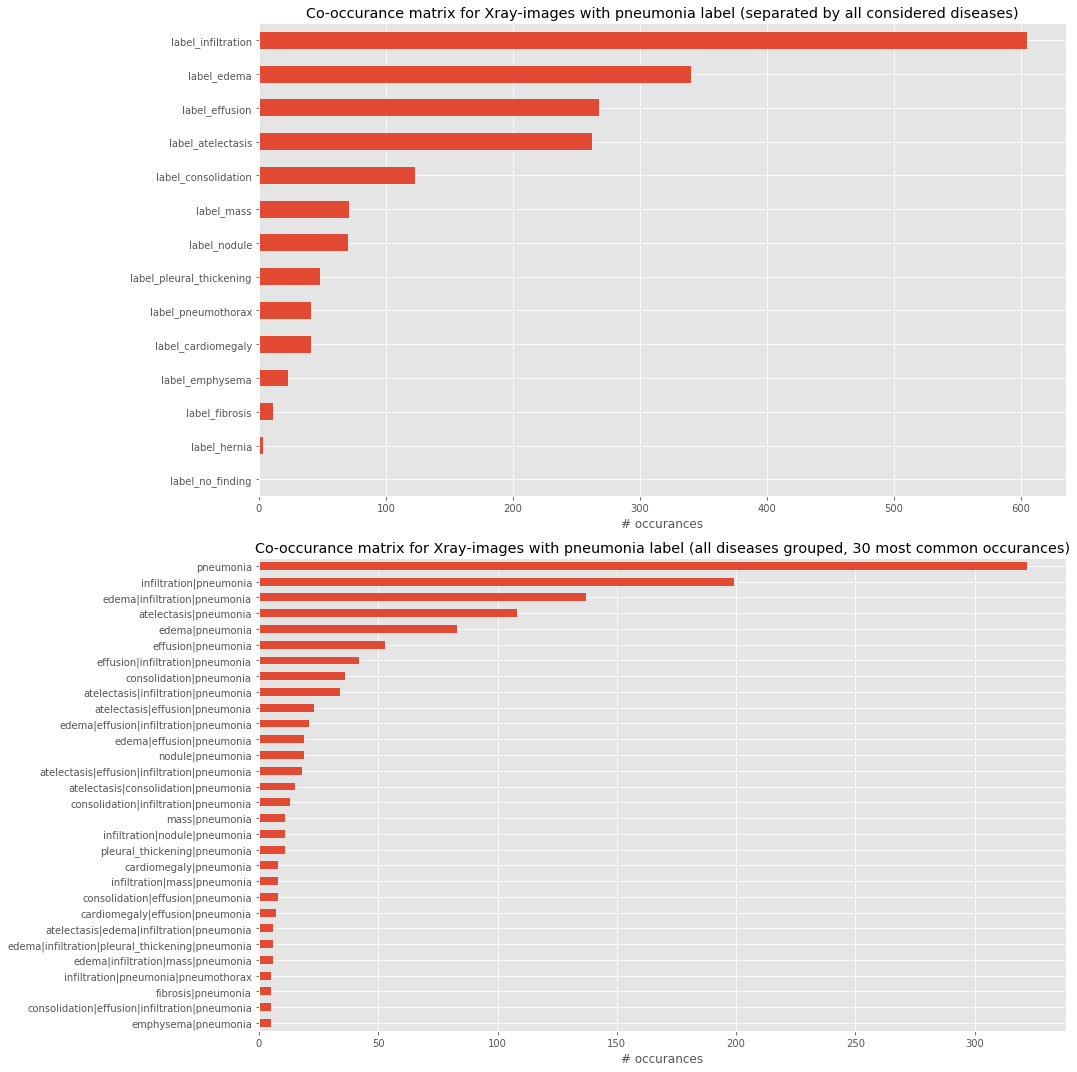

In [27]:
fig, axarr = plt.subplots(2, 1, figsize=(15, 15))
ttl = 'Co-occurance matrix for Xray-images with pneumonia label (separated by all considered diseases)'
(df_pneumonia.loc[:, df_pneumonia.columns.str.startswith('label')]
 .sum()
 .sort_values(ascending=False)
 .plot.barh(ax=axarr[0], title=ttl))
axarr[0].set_xlabel('# occurances')
axarr[0].invert_yaxis()

ttl = 'Co-occurance matrix for Xray-images with pneumonia label (all diseases grouped, 30 most common occurances)'
df_pneumonia['finding_labels'].value_counts()[:30].plot.barh(ax=axarr[1], title=ttl)
axarr[1].set_xlabel('# occurances')
axarr[1].invert_yaxis()

fig.tight_layout()
plt.savefig(f'{path_figures}cooccurance_matrices.png', bbox_inches='tight')

## Pixel-Level Assassements
Pixel-level assessments of the imaging data for healthy & disease states of interest
- histograms of intensity values
- comparing distributions across diseases

we use `sample_labels.csv` for the pixel-level assassements. 

In [28]:
print(f"# pneumonia diseases in the sample df: {df_sample['label_pneumonia'].sum()}")
print(f"# pneumonia diseases in the complete df: {df['label_pneumonia'].sum()}")

# pneumonia diseases in the sample df: 62
# pneumonia diseases in the complete df: 1430


In [29]:
sers = df_sample.loc[df_sample['finding_labels']=='pneumonia', 'file_path']

In [30]:
def imread_int(filename: str) -> np.array:
    return np.asarray(PIL.Image.open(filename))


def get_px_values(images: typing.Union[list, pd.Series]) -> np.array:
    pxs = np.array([])
    for pth in tqdm.tqdm(images):
        pxs = np.append(pxs, imread_int(filename=pth).ravel())
    return pxs

In [31]:
pxs = get_px_values(images=sers)

100%|██████████| 14/14 [00:00<00:00, 48.49it/s]


- Pixel intensity distribution of all pneumonia disease images
- Pixel intensity distribution of all images containing pneumonia disease
- Pixel intensity distribution of {} disease

In [32]:
df_sample.loc[df_sample['finding_labels']=='pneumonia', 'file_path'].sample(1).iloc[0]

'data/images_010/images/00021127_018.png'

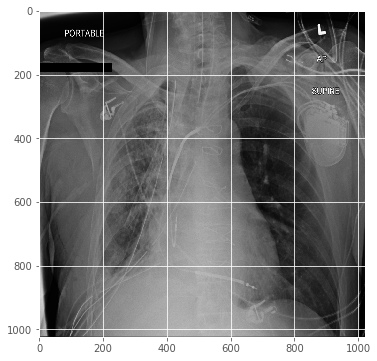

In [33]:
img = plt.imread(df_sample.loc[0, 'file_path'])
plt.imshow(img, cmap='gray')

100%|██████████| 10/10 [00:00<00:00, 58.40it/s]


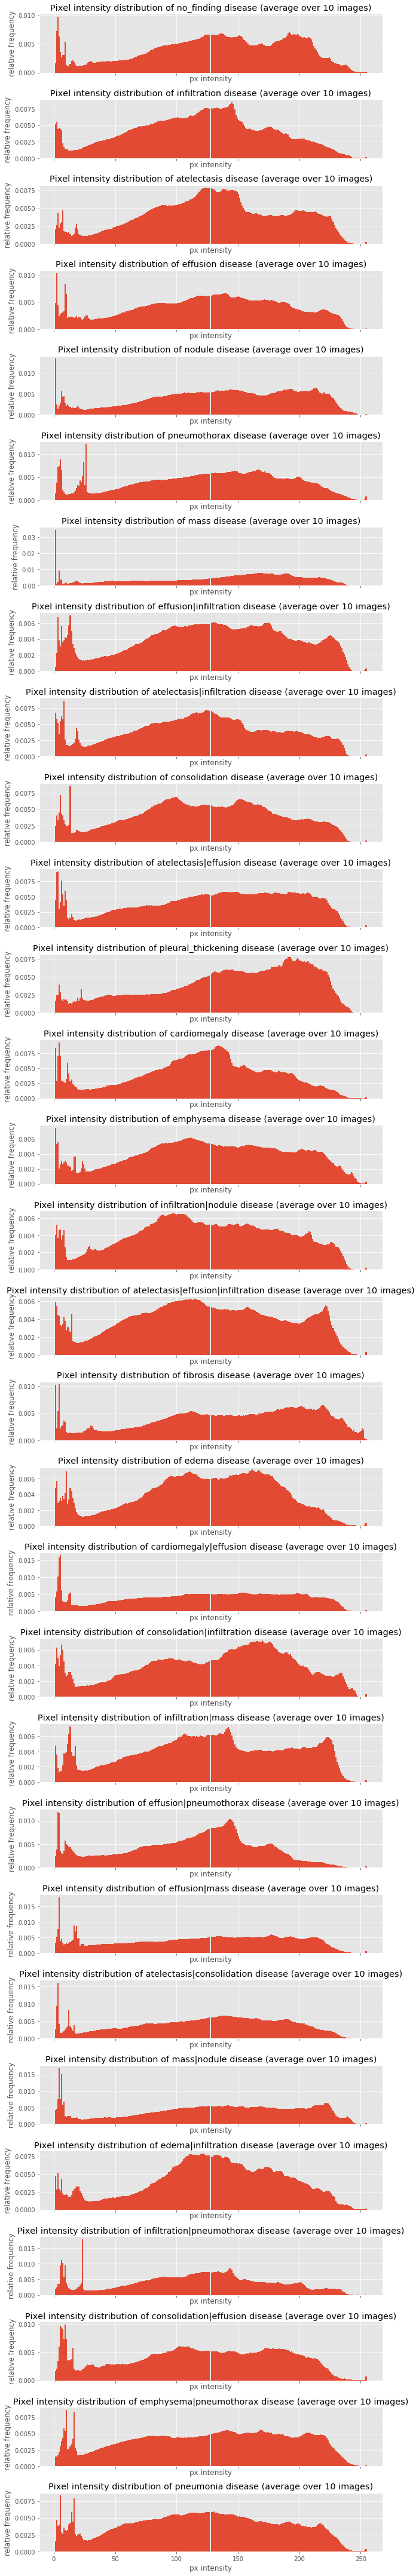

In [34]:
nr_plots = 30
sample_size = 10
fig, axarr = plt.subplots(nr_plots, 1, figsize=(10, nr_plots*2), sharex=True)
for i, disease in enumerate(df['finding_labels'].value_counts()[:nr_plots].index):
    pths = df_sample.loc[df_sample['finding_labels']==disease, 'file_path'].sample(sample_size)
    pxs = get_px_values(images=pths)
    axarr[i].hist(pxs[pxs>0], bins=256, weights=np.zeros_like(pxs[pxs>0]) + 1. / (pxs[pxs>0]).size)
#     axarr[i].hist(pxs[pxs>0], bins=256)
#     axarr[i].hist(pxs, bins=256)
    axarr[i].set_title(f'Pixel intensity distribution of {disease} disease (average over {sample_size} images)')
    axarr[i].set_xlabel('px intensity')
    axarr[i].set_ylabel('relative frequency')

fig.tight_layout()
plt.savefig(f'{path_figures}px_intensities_averaged.png', bbox_inches='tight')

100%|██████████| 1/1 [00:00<00:00, 107.26it/s]


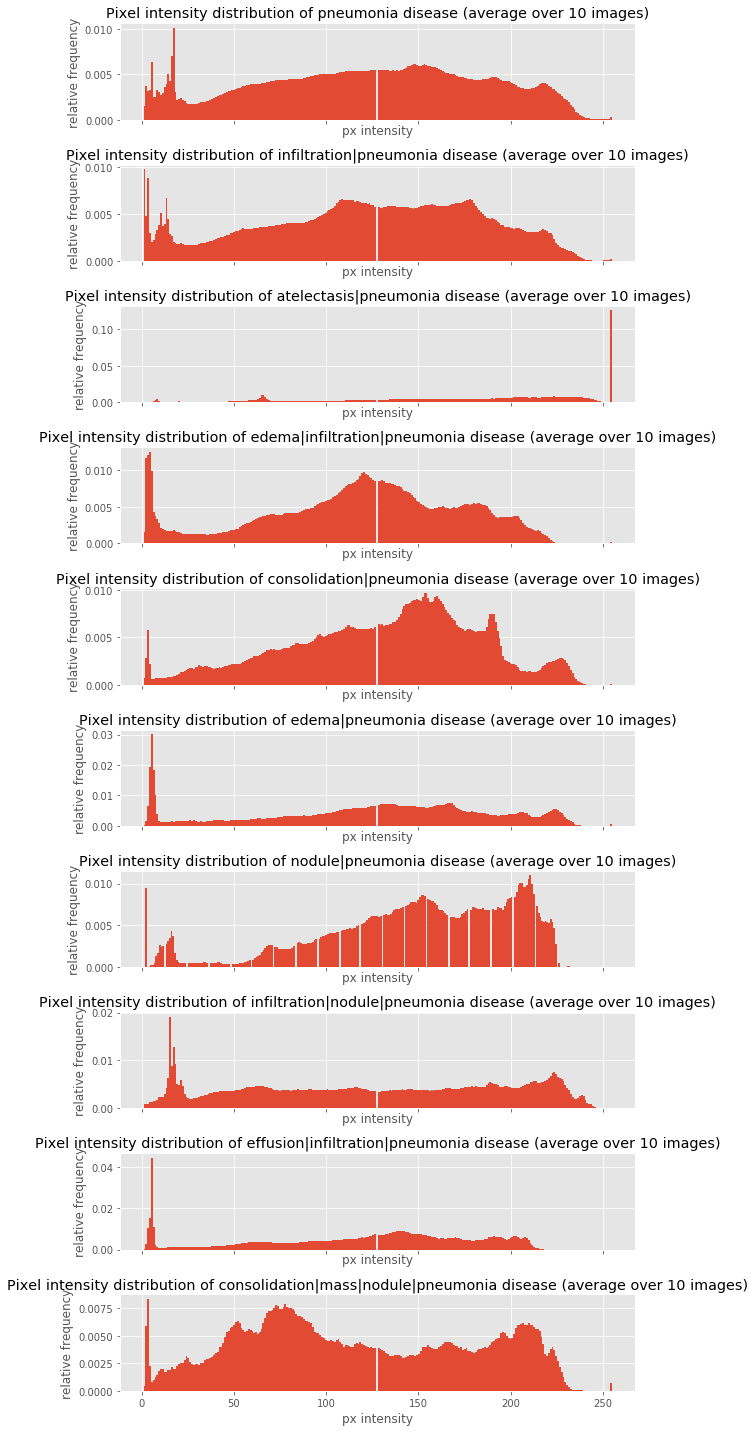

In [35]:
nr_plots = 10
sample_size = 10
fig, axarr = plt.subplots(nr_plots, 1, figsize=(10, nr_plots*2), sharex=True)
iterate = df_sample.loc[df_sample['finding_labels'].str.contains('pneumonia'), 'finding_labels'].value_counts()[:nr_plots].index
for i, disease in enumerate(iterate):
    pths = df_sample.loc[df_sample['finding_labels']==disease, 'file_path']#.sample(sample_size)
    pxs = get_px_values(images=pths)
    axarr[i].hist(pxs[pxs>0], bins=256, weights=np.zeros_like(pxs[pxs>0]) + 1. / (pxs[pxs>0]).size)
#     axarr[i].hist(pxs[pxs>0], bins=256)
#     axarr[i].hist(pxs, bins=256)
    axarr[i].set_title(f'Pixel intensity distribution of {disease} disease (average over {sample_size} images)')
    axarr[i].set_xlabel('px intensity')
    axarr[i].set_ylabel('relative frequency')

fig.tight_layout()
plt.savefig(f'{path_figures}px_intensities_pneumonia_averaged.png', bbox_inches='tight')

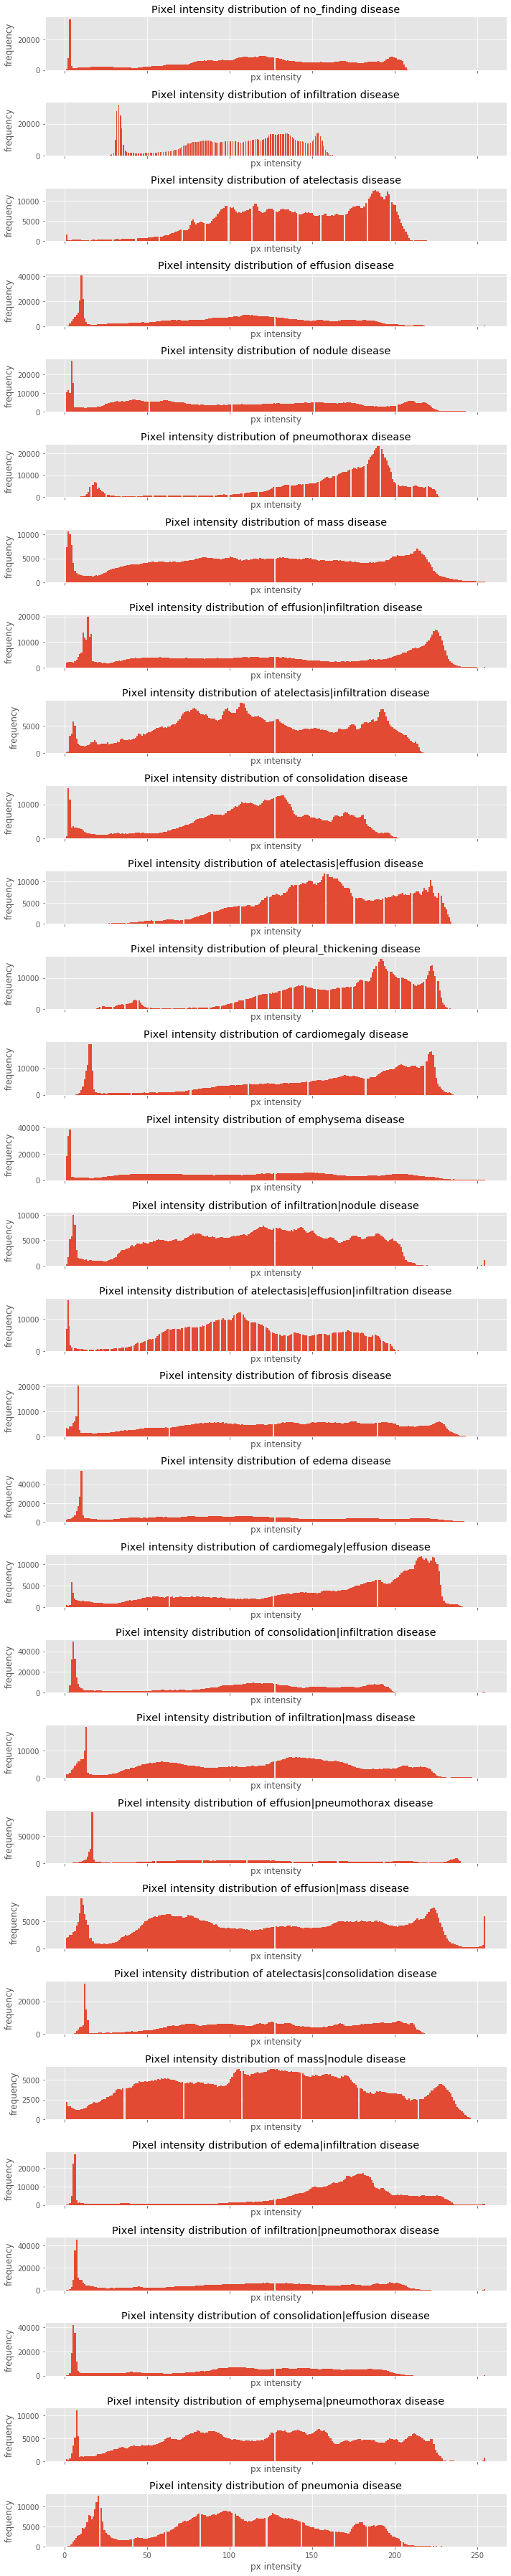

In [36]:
fig, axarr = plt.subplots(30, 1, figsize=(10, 50), sharex=True)
for i, disease in enumerate(df['finding_labels'].value_counts()[:30].index):
    pth = df_sample.loc[df_sample['finding_labels']==disease, 'file_path'].sample(1).iloc[0]
    pxs = imread_int(pth).ravel()
    axarr[i].hist(pxs[pxs>0], bins=256)
    axarr[i].set_title(f'Pixel intensity distribution of {disease} disease')
    axarr[i].set_xlabel('px intensity')
    axarr[i].set_ylabel('frequency')
    
fig.tight_layout()
plt.savefig(f'{path_figures}px_intensities_sample.png', bbox_inches='tight')

## Conclusion

Here we will describe the findings of the detailed data analysis.
From this we will conclude how we could set up the model training (training dataset, validation dataset).

The numbers below sould be considered as rough estimations.
As described above there are some errors in the dataset (regarding patient age and scan follow-ups).
These images will be removed from the training and validation dataset.

In [37]:
(df['label_pneumonia']==1).sum()

1430

In [38]:
(1 - ((df['label_pneumonia']==1).sum() / df.shape[0]))/((df['label_pneumonia']==1).sum() / df.shape[0]) * 286

22134.8

### Dataset sizes
- We are going to make a train test split of 0.8/0.2
- we have ~ 1430 images with pneumonia
- training set: 
    - t = 0.8 * (df['label_pneumonia']==1).sum() = 0.8 * 1430 = 1144 images with positive pneumonia cases
    - t = 1144 images with negative pneumonia cases
    - Note: we are going to train our CNN model on a balanced dataset. We could also train on an imbalanced traing set (with more negative labels than positive) by introducing a sample weight in the loss function. This would punish missclassifications of one sort harder than others.
    - training set cardinality: 2288
- validation set:
    - $v_p$ = 0.2 * (df['label_pneumonia']==1).sum() = 0.2 * 1430 = 286 images with positive pneumonia cases
    - how many negative cases should we add to the validation set? our best guess of how often pneumonia occures 'in the wild' is to look at the complete available dataset and get the ratio between pneumonia and non-pneumonia cases: $p_\text{pneumonia}$ = (df['label_pneumonia']==1).sum() / df.shape[0] = 1430 / 112104 = 1.28%. This means we could use $\frac{1 - p_\text{pneumonia}}{p_\text{pneumonia}} \cdot v_p = 22135$
    - validation set cardinality: 22421

How do the datasets have to look like:

- pneumonia images:
    -
- training set:
    

1. We split the complete dataset by 'pid' (patients) because we do not want to have the same patient in training and testing set. We have to ensure that training set contains ~0.8 of pneumonia cases. It should also maintain the pneumonia co-occurance matrices, the gender and age distribution
2. 

- describe findings
- how will you set up the model training based on the findings

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.


- what ages it affects
- how often it is found? this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 
- what other types of diseases it's commonly found with